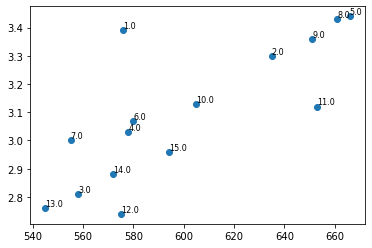

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV
law = pd.read_csv('law.csv')

# Add observation column
law['observation'] = range(1, len(law) + 1)

# Plot data
fig, ax = plt.subplots()
ax.scatter(x=law['LSAT'], y=law['GPA'])
for i, row in law.iterrows():
    ax.text(row['LSAT'], row['GPA'], row['observation'], horizontalalignment='left', verticalalignment='bottom', fontsize=8)
plt.show()


#####  The nonparametric bootstrap distribution of the Pearson’s correlation coefficient between LSAT and GPA using B = 40000 bootstrap samples (lab exercise)

In [3]:
import numpy as np
import pandas as pd

# Load the data
law = pd.read_csv('law.csv')

# Compute the observed correlation coefficient
obs_corr = law['LSAT'].corr(law['GPA'])

# Set the number of bootstrap samples
B = 40000

# Create an empty array to store the bootstrap samples
bootstrap_corr = np.zeros(B)

# Generate B bootstrap samples
for i in range(B):
    # Sample with replacement from the data
    bootstrap_sample = law.sample(n=len(law), replace=True)
    # Compute the correlation coefficient of the bootstrap sample
    bootstrap_corr[i] = bootstrap_sample['LSAT'].corr(bootstrap_sample['GPA'])

# Compute the bootstrap standard error and 95% confidence interval
se_boot = np.std(bootstrap_corr)
lower_ci_boot = np.percentile(bootstrap_corr, 2.5)
upper_ci_boot = np.percentile(bootstrap_corr, 97.5)

# Print the results
print("Observed correlation coefficient: {:.3f}".format(obs_corr))
print("Bootstrap standard error: {:.3f}".format(se_boot))
print("95% Confidence interval: ({:.3f}, {:.3f})".format(lower_ci_boot, upper_ci_boot))


Observed correlation coefficient: 0.776
Bootstrap standard error: 0.134
95% Confidence interval: (0.457, 0.961)


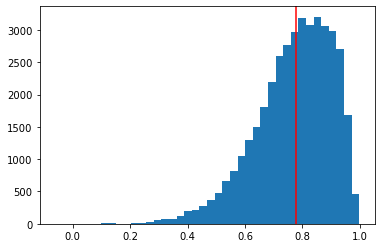

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load data into pandas DataFrame
law = pd.read_csv("law.csv")

# Calculate Pearson's correlation coefficient
theta_hat = np.corrcoef(law['LSAT'], law['GPA'])[0, 1]

# Define bootstrap function
def boot():
    n = len(law)
    ind = np.random.choice(n, n, replace=True)
    return np.corrcoef(law.iloc[ind]['LSAT'], law.iloc[ind]['GPA'])[0, 1]

# Run bootstrap
B = 40000
theta_star = np.array([boot() for i in range(B)])

# Plot results
plt.hist(theta_star, bins=40)
plt.axvline(x=theta_hat, color='r', linewidth=1.5)
plt.show()
